# Table of Contents in this notebook 

* [Preliminaries](#preliminaries)
* [Inference using a pre-trained model](#inference_pretrained)
* [Architecture](#architecture)
    * [Backbone](#backbone)
    * [Position embedding](#position_embedding)
    * [Transformer](#transformer)
        * [Encoder](#encoder)
        * [Decoder](#decoder)
    * [Feed-forward networks (FFNs)](#ffn)
* [Train & test](#train_and_test)
    * [Train](#train)
    * [Test](#test)

# Preliminaries <a class="anchor" id="preliminaries"></a>

In [1]:
!pip install easydict
!pip install pycocotools

In [2]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T

%load_ext autoreload
%autoreload 2

In [3]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [4]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [5]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [85]:
def info(data, name, rspace=10, end='\n'):
    if torch.is_tensor(data):
        info_t(data, name, rspace=rspace, end=end)
    elif isinstance(data, list):
        info_l(data, name, rspace=rspace, end=end)
    elif isinstance(data, dict):
        info_d(data, name, rspace=rspace, end=end)
    elif hasattr(data, '__class__'):
        info_any(data, name, f'type={data.__class__.__name__}', rspace=rspace, end=end)
    else:
        info_any(data, name, f'type={data.dtype}', rspace=rspace, end=end)

def info_v(data, name, rspace=10, end='\n'):
    print(f"{name.rjust(rspace)}: {data}", end=end)
def info_t(data, name, rspace=10, end='\n'):
    print(f"{name.rjust(rspace)}: ({data.shape})", end=end)
def info_l(data, name, rspace=10, end='\n'):
    print(f"{name.rjust(rspace)}: {len(data)} <- ({data[0].shape})", end=end)
def info_d(data, name, rspace=10, end='\n'):
    keys = [k for k, v in data.items()]
    values = [v for k, v in data.items()]
    print(f"{name.rjust(rspace)}: ", end='\n')
    for i in range(len(keys)):
        print(f"  > ", end=''); info(values[i], keys[i], end=end)
        
def info_any(data, name, add_string, rspace=10, end='\n'):
    print(f"{name.rjust(rspace)}: {add_string}", end=end)

# Inference using a pre-trained model <a class='anchor' id='inference_pretrained'></a>

In [7]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


In [8]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

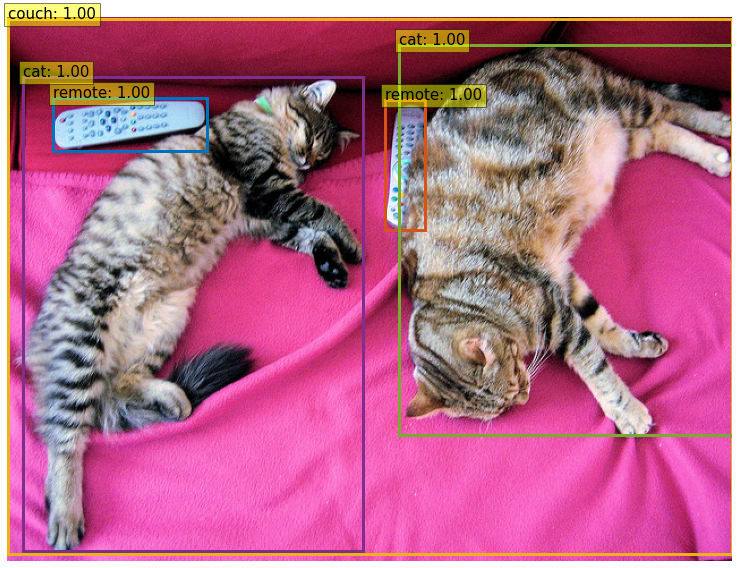

In [9]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)

# Architecture <a class='anchor' id='architecture'></a>

In [10]:
from dscv.utils.param_manager import ParamManager
pm = ParamManager()
pm.check_param_structure(model)

transformer: 
  ├ encoder: 
  ├   ├ layers: 
  ├   ├   ├ 0: 
  ├   ├   ├   ├ self_attn: 
  ├   ├   ├   ├   ├ out_proj: 
  ├   ├   ├   ├ linear1: 
  ├   ├   ├   ├ dropout: 
  ├   ├   ├   ├ linear2: 
  ├   ├   ├   ├ norm1: 
  ├   ├   ├   ├ norm2: 
  ├   ├   ├   ├ dropout1: 
  ├   ├   ├   ├ dropout2: 
  ├   ├   ├ 1: 
  ├   ├   ├   ├ self_attn: 
  ├   ├   ├   ├   ├ out_proj: 
  ├   ├   ├   ├ linear1: 
  ├   ├   ├   ├ dropout: 
  ├   ├   ├   ├ linear2: 
  ├   ├   ├   ├ norm1: 
  ├   ├   ├   ├ norm2: 
  ├   ├   ├   ├ dropout1: 
  ├   ├   ├   ├ dropout2: 
  ├   ├   ├ 2: 
  ├   ├   ├   ├ self_attn: 
  ├   ├   ├   ├   ├ out_proj: 
  ├   ├   ├   ├ linear1: 
  ├   ├   ├   ├ dropout: 
  ├   ├   ├   ├ linear2: 
  ├   ├   ├   ├ norm1: 
  ├   ├   ├   ├ norm2: 
  ├   ├   ├   ├ dropout1: 
  ├   ├   ├   ├ dropout2: 
  ├   ├   ├ 3: 
  ├   ├   ├   ├ self_attn: 
  ├   ├   ├   ├   ├ out_proj: 
  ├   ├   ├   ├ linear1: 
  ├   ├   ├   ├ dropout: 
  ├   ├   ├   ├ linear2: 
  ├   ├   ├   ├ norm1: 
  ├   ├   ├  

## Backbone <a class='anchor' id='backbone'></a>

<b>Input:</b>
* `img` : {Tensor} (B, 3, img_H, img_W) : $x_\text{img}\in\mathbb{R}^{3\times H_0\times W_0}$
    
<b>Process:</b> Extract feature from img

<b>Output:</b>
* `features`: {Tensor} (B, C, H, W) e.g. (1, 2048, 25, 34): $f\in\mathbb{R}^{C\times H\times W}$, where $C=2048$ and $H,W=\frac{H_0}{32},\frac{W_0}{32}$.

In [11]:
def visualize_multiple_data(data, rows=5, cols=10, show=True, scale=1.5):
    (num_data, h, w) = data.shape
    fig, axes = plt.subplots(rows, cols, figsize=(cols*w/96*scale, rows*h/96*scale))
    r, c = 0, 0
    for i in range(num_data):
        axes[r, c].imshow(data[i])
        axes[r, c].axis('off')
        c += 1
        if c == cols:
            c = 0; r += 1;
            if r == rows:
                break
    if show:
        plt.show()
    return fig, axes

   samples: (tensors:torch.Size([1, 3, 800, 1066]), mask:torch.Size([1, 800, 1066]))
  features: 1 <- (tensors:torch.Size([1, 2048, 25, 34]), mask:torch.Size([1, 25, 34]))
       pos: 1 <- (torch.Size([1, 256, 25, 34]))
conv_features: 
  >          0: type=NestedTensor


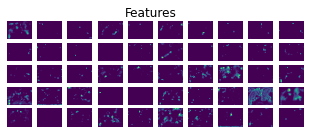

In [86]:
from thirdparty.detr.util.misc import nested_tensor_from_tensor_list

# Hook
conv_features =[]
hooks = []
hooks.append(model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)))

samples = nested_tensor_from_tensor_list(img)
info_any(samples, 'samples', f'(tensors:{samples.tensors.shape}, mask:{samples.mask.shape})')

features, pos = model.backbone(samples)
info_any(features, 'features', f'{len(features)} <- (tensors:{features[0].tensors.shape}, mask:{features[0].mask.shape})')
info_l(pos, 'pos')
conv_features = conv_features[0]; info(conv_features, 'conv_features')

# Visualize
fig, axes = visualize_multiple_data(features[0].tensors[0].cpu().detach().numpy(), 5, 10, show=False)
fig.suptitle('Features')
plt.show()
plt.close(fig)

## Position embedding <a class='anchor' id='position_embedding'></a>

<b>Input:</b>
* `features` : {Tensor} (B, C, H, W) e.g. (1, 2048, 25, 34)
    
<b>Process:</b> Embed position into features

<b>Output:</b>
* `pos`: {Tensor} (B, num_pos_feats, H, W) e.g. (1, 256, 25, 34)

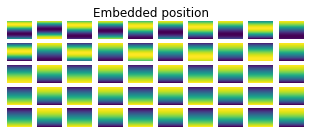

In [13]:
# Visualize
fig, axes = visualize_multiple_data(pos[0][0].cpu().detach().numpy(), 5, 10, show=False)
fig.suptitle('Embedded position')
plt.show()
plt.close(fig)

## Transformer <a class='anchor' id='transformer'></a>

### Encoder <a class='anchor' id='encoder'></a>

<b>Input:</b>
* `features` : {Tensor} (B, C, H, W) e.g. (1, 2048, 25, 34)
* `mask` : {Tensor} (B, H, W) e.g. (1, 25, 34)
    
<b>Process:</b>
1. A $1\times 1$ CONV reduces the channel dimension of the high-level activation map $f$ from $C$ to a samller dimension $d$.
2. Collapse the spatial dimensions of $z_0$ into one dimension, resulting in a $d\times HW$ feature map.
3. Encode

<b>Output:</b>
* `memory`: {Tensor} (HW,B,d) e.g. (850, 1, 256)

       src: (torch.Size([1, 256, 25, 34]))


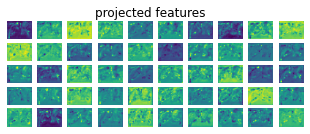


The encoder expects a sequence as input.
Therefore, the dimension of inputs (src, pos_embed, query_embed, and mask) are collapsed.
       src: (torch.Size([850, 1, 256]))   (B,d,H,W)->(HW,B,d)
 pos_embed: (torch.Size([850, 1, 256]))   (B,d,H,W)->(HW,B,d)
query_embed: (torch.Size([100, 1, 256]))  (num_obj_queries, d)->(num_obj_queries, B, d)
      mask: (torch.Size([1, 850]))        (B,H,W)->(B,HW)

In [14]:
# A 1x1 CONV reduces the channel dimension of the high-level activation map f from C to d.
src, mask = features[-1].decompose()
src = model.input_proj(src)
info_t(src, 'src')

# Visualize
fig, axes = visualize_multiple_data(src[0].cpu().detach().numpy(), 5, 10, show=False)
fig.suptitle('projected features')
plt.show()
plt.close(fig)

print('')
# Collapse the spatial dimensions of z_0 into one dimension, resulting in a dxHW feature map.
bs, c, h, w = src.shape
src = src.flatten(2).permute(2, 0, 1) # (B, C, HW) -> (HW, B, C)
pos_embed = pos[-1].flatten(2).permute(2, 0, 1) # (B, d, HW) -> (HW, B, d)
query_embed = model.query_embed.weight.unsqueeze(1).repeat(1, bs, 1) # TODO:?
mask = mask.flatten(1)
print(f"The encoder expects a sequence as input.")
print(f"Therefore, the dimension of inputs (src, pos_embed, query_embed, and mask) are collapsed.")
info_t(src, 'src', end='   (B,d,H,W)->(HW,B,d)\n')
info_t(pos_embed, 'pos_embed', end='   (B,d,H,W)->(HW,B,d)\n')
info_t(query_embed, 'query_embed', end='  (num_obj_queries, d)->(num_obj_queries, B, d)\n')
info_t(mask, 'mask', end='        (B,H,W)->(B,HW)')


TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
  )
  (linear1): Linear(in_features=256, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=256, bias=True)
  (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)
encoder output (memory): (torch.Size([850, 1, 256]))    encodes src(HW,B,d) to (HW,B,d)enc_attn_weights: (torch.Size([850, 1, 256]))


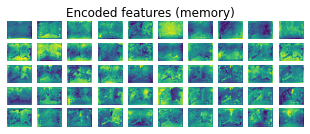

In [105]:
encoder = model.transformer.encoder

output = src
cnt = 0
for layer in encoder.layers:
    output = layer(output, src_mask=None,
                   src_key_padding_mask=mask, pos=pos_embed) # TODO
    cnt += 1
    if cnt == len(encoder.layers):
        enc_attn_weights = output
        print(layer)
memory = output
    
info_t(memory, 'encoder output (memory)', end='    encodes src(HW,B,d) to (HW,B,d)')
info(enc_attn_weights, 'enc_attn_weights')

# Visualize
_output = output.permute(1, 2, 0).unsqueeze(-1).reshape(1, 256, 25, 34)
fig, axes = visualize_multiple_data(_output[0].cpu().detach().numpy(), 5, 10, show=False)
fig.suptitle('Encoded features (memory)')
plt.show()
plt.close(fig)

### Decoder <a class='anchor' id='decoder'></a>

<b>Input:</b>
* `memory`: {Tensor} (HW,B,d) e.g. (850, 1, 256)
    
<b>Process:</b> 
1. Decodes the $N$ objects in parallel at each decoder layer.

<b>Output:</b>
* `hs`: {Tensor} (B, num_obj_queries, d) e.g. (1, 100, 256)

In [104]:
decoder = model.transformer.decoder

output = torch.zeros_like(query_embed)
intermediate = []
for layer in decoder.layers:
    output = layer(output, memory, 
                   tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None,
                   memory_key_padding_mask=mask,
                   pos=pos_embed, query_pos=query_embed)
    print(output.shape)
    if decoder.return_intermediate:
        intermediate.append(decoder.norm(output))
info_l(intermediate, 'intermediate')
        
if decoder.norm is not None:
    output = decoder.norm(output)
    if decoder.return_intermediate:
        intermediate.pop()
        intermediate.append(output)
info_l(intermediate, 'intermediate')

if decoder.return_intermediate:
    hs = torch.stack(intermediate)
hs = hs.transpose(1, 2)
info_l(hs, 'hs')

dec_attn_weights = [hs[-1]]
info(dec_attn_weights[0], 'dec_attn_weights')

torch.Size([100, 1, 256])
torch.Size([100, 1, 256])
torch.Size([100, 1, 256])
torch.Size([100, 1, 256])
torch.Size([100, 1, 256])
torch.Size([100, 1, 256])
intermediate: 6 <- (torch.Size([100, 1, 256]))
intermediate: 6 <- (torch.Size([100, 1, 256]))
        hs: 6 <- (torch.Size([1, 100, 256]))
dec_attn_weights: (torch.Size([1, 100, 256]))


**Visualize**

conv_features: 
  >          0: type=NestedTensor   <- torch.Size([1, 2048, 25, 34])
enc_attn_weights: (torch.Size([850, 1, 256]))
dec_attn_weights: 1 <- (torch.Size([1, 100, 256]))


TypeError: Image data of dtype object cannot be converted to float

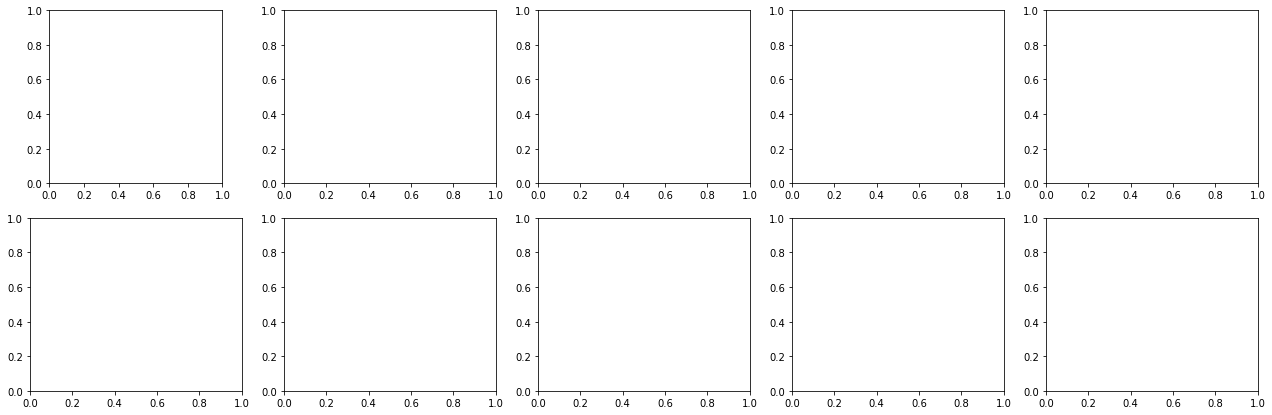

In [103]:
info(conv_features, 'conv_features', end=''); print(f"   <- {conv_features['0'].tensors.shape}")
info(enc_attn_weights, 'enc_attn_weights')
info(dec_attn_weights, 'dec_attn_weights')

# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    # idx : keep 
    
    ax = ax_i[0]
    # ax.imshow(enc_attn_weights[:,0,idx].view(h, w).detach().cpu().numpy())
    ax.imshow(dec_attn_weights)
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

## Feed-forward networks (FFNs) <a class='anchor' id='ffn'></a>

<b>Input:</b>
* `hs`: {Tensor} (B, num_obj_queries, d) e.g. (1, 100, 256)
    
<b>Process:</b> 
1. FFN predicts the normalized center coordinates, height and width of the box w.r.t. the input image
2. Linear layer predicts the class label using a softmax function

<b>Output:</b>
* `out`: {Dict} 
    * `pred_logits`: {Tensor} (B, num_obj_queries, num_classes+1) e.g. (1, 100, 92)
    * `pred_boxes`: {Tensor} (B, num_obj_queries, 4) e.g. (1, 100, 4)

pred_logits: (torch.Size([1, 100, 92]))
pred_boxes: (torch.Size([1, 100, 4]))
probabilities: (torch.Size([100, 91]))
      keep: (torch.Size([100]))


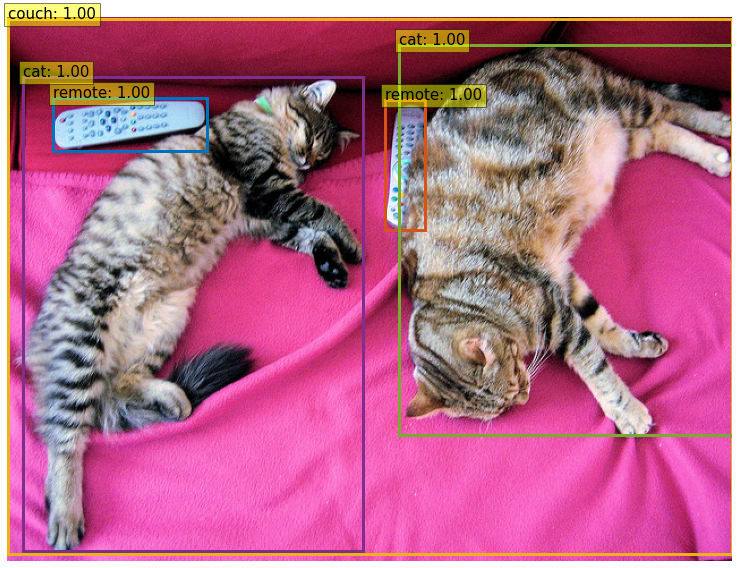

probabilities[keep]: (torch.Size([5, 91]))
bboxes_scaled: (torch.Size([5, 4]))


In [94]:
outputs_class = model.class_embed(hs)
outputs_coord = model.bbox_embed(hs).sigmoid()
out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1]}
info_t(out['pred_logits'], 'pred_logits')
info_t(out['pred_boxes'], 'pred_boxes')

# Visualize
probabilities = out['pred_logits'].softmax(-1)[0, :, :-1]
keep = probabilities.max(-1).values > 0.9
info_t(probabilities, 'probabilities')
info_t(keep, 'keep')

bboxes_scaled = rescale_bboxes(out['pred_boxes'][0, keep], im.size)
plot_results(im, probabilities[keep], bboxes_scaled)
info_t(probabilities[keep], 'probabilities[keep]')
info_t(bboxes_scaled, 'bboxes_scaled')

# Train & test <a class='anchor' id='train_and_test'></a>

## Train <a class='anchor' id='train'></a>
```python
outputs = model(samples)
loss_dict = criterion(outputs, targets)
weight_dict = criterion.weight_dict
losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
optimizer.zero_grad()
losses.backward()
optimizer.step()
```

In [334]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}
    
model = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
model.load_state_dict(state_dict)
model.eval();

In [335]:
import os
import numpy as np
from torch.utils.data import Dataset
from pycocotools.coco import COCO

class CocoDataset(Dataset):
    def __init__(self, data_root, ann_file, img_prefix, pipeline, split='train'):
        super(CocoDataset, self).__init__()
        self.data_root = data_root
        self.ann_file = ann_file
        self.img_prefix = img_prefix
        self.pipeline = pipeline
        self.split = split

        self.CLASSES = ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
               'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
               'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
               'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
               'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
               'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
               'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
               'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
               'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
               'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
               'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
               'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
               'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
               'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush')

        self.coco = COCO(os.path.join(self.data_root, self.ann_file))
        self.img_ids = self.coco.getImgIds()

        self.data_infos = []
        self.ann_ids = []
        for i in self.img_ids:
            info = self.coco.loadImgs(ids=i)[0]
            info['filename'] = info['file_name']
            self.data_infos.append(info)

            ann_id = self.coco.getAnnIds(imgIds=i)
            self.ann_ids.append(ann_id)

        cat_ids = self.coco.getCatIds(self.CLASSES)
        self.cat2label = {cat_id: i for i, cat_id in enumerate(cat_ids)}

    def __len__(self):
        return len(self.img_ids)

    ''' Get Item '''
    def __getitem__(self, idx):
        data = dict()

        # Image
        data['image'] = self.load_image(idx)

        # Annotations: Bounding box and labels
        annotations = self.load_annotations(idx)
        bboxes = torch.FloatTensor(annotations[:, :4])
        labels = torch.FloatTensor(annotations[:, 4])
        data['bboxes'] = bboxes
        data['labels'] = labels

        return data

    def load_image(self, idx):
        '''
        Output:
            image: (PIL)
        '''
        img_info = self.data_infos[idx]
        file_path = os.path.join(self.img_prefix, img_info['filename'])

        image = Image.open(file_path).convert('RGB')

        for t in self.pipeline:
            image = t(image)

        return image

    def load_annotations(self, idx):
        ann_id = self.ann_ids[idx]
        anns = self.coco.loadAnns(ann_id)

        annotations = np.zeros((0, 5))
        for i, anno_dict in enumerate(anns):
            if anno_dict['bbox'][2] < 1 or anno_dict['bbox'][3] < 1:
                continue

            annotation = np.zeros((1, 5))
            # (x1, y1, w, h) -> (cx, cy, w, h)
            x1, y1, w, h = anno_dict['bbox']
            annotation[0, 0] = x1 + w / 2.
            annotation[0, 1] = y1 + h / 2.
            annotation[0, 2] = w
            annotation[0, 3] = h
            annotation[0, 4] = anno_dict['category_id']
            annotations = np.append(annotations, annotation, axis=0)

        return annotations

    ''' Helper '''
    @staticmethod
    def xywh2xyxy(x, y=None, w=None, h=None):
        if y is None:
            x, y, w, h = x[0], x[1], x[2], x[3]
        x1 = x - w
        x2 = x + w
        y1 = y - h
        y2 = y + h
        return (x1, x2, y1, y2)

    @staticmethod
    def xyxy2xywh(x1, y1=None, x2=None, y2=None):
        if x2 is None:
            x1, y1, x2, y2 = x1[0], x1[1], x1[2], x1[3]
        x = (x1 + x2) / 2.0
        y = (y1 + y2) / 2.0
        w = (x2 - x1) / 2.0
        h = (y2 - y1) / 2.0
        return (x, y, w, h)

In [336]:
data_root = '/ws/data/coco_mini10'
ann_file = 'annotations/instances_train2017.json'
img_prefix = f'{data_root}/train2017'
pipeline = [torchvision.transforms.ToTensor()]
dataset = CocoDataset(data_root, ann_file, img_prefix, pipeline, split='train')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


     image: (torch.Size([3, 360, 640]))
    labels: (torch.Size([4]))
    bboxes: (torch.Size([4, 4]))
   targets: 1 <- labels(torch.Size([4])), boxes(torch.Size([4, 4]))


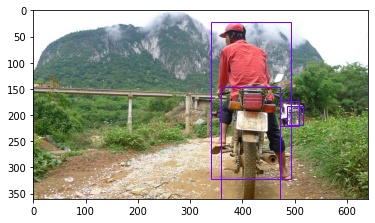

In [337]:
image = dataset[0]['image']
labels = dataset[0]['labels']
bboxes = dataset[0]['bboxes']
info_t(image, 'image')
info_t(labels, 'labels')
info_t(bboxes, 'bboxes')

# targets = torch.cat([bboxes, labels.unsqueeze(-1)], dim=1).unsqueeze(0)

def re_rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b / torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def box_xyxy_to_cxcywh(x):
    x1, y1, x2, y2 = x.unbind(1)
    b = [(x2 + x1) / 2.0, (y2 + y1) / 2.0,
         (x2 - x1), (y2 - y1)]
    return torch.stack(b, dim=1)

image_size = (image.shape[-1], image.shape[-2])
rerescaled_bboxes = re_rescale_bboxes(bboxes, image_size)
rerescaled_bboxes = box_xyxy_to_cxcywh(rerescaled_bboxes)

targets = [dict(labels=labels.type(torch.LongTensor), boxes=rerescaled_bboxes)]
info_any(targets, 'targets', f"{len(targets)} <- labels({targets[0]['labels'].shape}), boxes({targets[0]['boxes'].shape})")

# Visualize
from dscv.utils.detection_utils import visualize_bboxes_cxcy
fig, ax = plt.subplots(1, 1)
ax.imshow(image.permute(1,2,0).detach().cpu().numpy())
fig, ax = visualize_bboxes_cxcy(bboxes, fig=fig, ax=ax)
ax.set_xlim(0, image.shape[2]); ax.set_ylim(image.shape[1], 0)
plt.show()

### Loss

pred_logits: (torch.Size([1, 100, 92]))
pred_boxes: (torch.Size([1, 100, 4]))


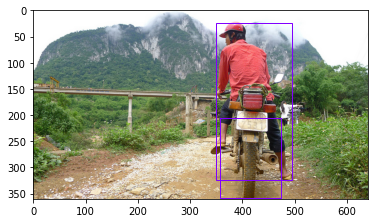

In [338]:
# propagate through the model
out = model(image.unsqueeze(0))
for k, v in out.items():
    info_t(v, f'{k}')
    
# Visualize
from dscv.utils.detection_utils import visualize_bboxes_xy
fig, ax = plt.subplots(1, 1)
ax.imshow(image.permute(1,2,0).detach().cpu().numpy())

probabilities = out['pred_logits'].softmax(-1)[0, :, :-1]
keep = probabilities.max(-1).values > 0.9

image_size = (image.shape[-1], image.shape[-2])
bboxes_scaled = rescale_bboxes(out['pred_boxes'][0, keep], image_size)

fig, ax = visualize_bboxes_xy(bboxes_scaled, fig=fig, ax=ax)
ax.set_xlim(0, image.shape[2]); ax.set_ylim(image.shape[1], 0)
plt.show()

**HungarianMathing**

In [339]:
from torchvision.ops.boxes import box_area
def box_iou(boxes1, boxes2):
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

    union = area1[:, None] + area2 - inter

    iou = inter / union
    return iou, union

def generalized_box_iou(boxes1, boxes2):
    """
    Generalized IoU from https://giou.stanford.edu/

    The boxes should be in [x0, y0, x1, y1] format

    Returns a [N, M] pairwise matrix, where N = len(boxes1)
    and M = len(boxes2)
    """
    # degenerate boxes gives inf / nan results
    # so do an early check
    assert (boxes1[:, 2:] >= boxes1[:, :2]).all()
    assert (boxes2[:, 2:] >= boxes2[:, :2]).all()
    iou, union = box_iou(boxes1, boxes2)

    lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    area = wh[:, :, 0] * wh[:, :, 1]

    return iou - (area - union) / area

In [340]:
from scipy.optimize import linear_sum_assignment

bs, num_queries = out['pred_logits'].shape[:2]

# We flatten to compute the cost matrices in a batch
out_prob = out["pred_logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
out_bbox = out["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]
info_t(out_prob, 'out_prob')
info_t(out_bbox, 'out_bbox')

# Also concat the target labels and boxes
tgt_ids = torch.cat([v["labels"] for v in targets])
tgt_bbox = torch.cat([v["boxes"] for v in targets])
info_t(tgt_ids, 'tgt_ids', end=f': {tgt_ids}\n')
info_t(tgt_bbox, 'tgt_bbox', end='\n\n')

# Compute the classification cost. Contrary to the loss, we don't use the NLL,
# but approximate it in 1 - proba[target class].
# The 1 is a constant that doesn't change the matching, it can be ommitted.
cost_class = -out_prob[:, tgt_ids]
info_t(cost_class, 'cost_class')

# Compute the L1 cost between boxes
cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)
info_t(cost_bbox, 'cost_bbox')

# Compute the giou cost betwen boxes
cost_giou = -generalized_box_iou(box_cxcywh_to_xyxy(out_bbox), box_cxcywh_to_xyxy(tgt_bbox))
info_t(cost_giou, 'cost_giou', end='\n\n')

# Final cost matrix
_cost_bbox = 1.0
_cost_class = 1.0
_cost_giou = 1.0
C = _cost_bbox * cost_bbox + _cost_class * cost_class + _cost_giou * cost_giou
C = C.view(bs, num_queries, -1).cpu()
info_t(C, 'C')

sizes = [len(v["boxes"]) for v in targets]
indices = [linear_sum_assignment(c[i].detach().numpy()) for i, c in enumerate(C.split(sizes, -1))]
indices = [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]
info_any(indices, 'indices', f"{len(indices)} <- ({indices[0][0].shape}, {indices[0][1].shape}): {indices}")

  out_prob: (torch.Size([100, 92]))
  out_bbox: (torch.Size([100, 4]))
   tgt_ids: (torch.Size([4])): tensor([4, 1, 1, 2])
  tgt_bbox: (torch.Size([4, 4]))

cost_class: (torch.Size([100, 4]))
 cost_bbox: (torch.Size([100, 4]))
 cost_giou: (torch.Size([100, 4]))

         C: (torch.Size([1, 100, 4]))
   indices: 1 <- (torch.Size([4]), torch.Size([4])): [(tensor([18, 40, 82, 83]), tensor([1, 0, 3, 2]))]


**Losses**

In [341]:
import torch.nn.functional as F

def _get_src_permutation_idx(indices):
    # permute predictions following indices
    batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)]) # [i, i, i, ...]
    src_idx = torch.cat([src for (src, _) in indices]) # [,,,]
    return batch_idx, src_idx
num_classes = 91
src_logits = out['pred_logits']

# Compute the average number of target boxes accross all nodes, for normalization purposes
num_boxes = sum(len(t["labels"]) for t in targets)
num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(out.values())).device)
num_boxes = torch.clamp(num_boxes, min=1).item()
info_any(num_boxes, 'num_boxes', f'{num_boxes}')

# Compute all the requested losses
losses = {}

 num_boxes: 4.0


In [342]:
#########################
### Loss_cls (labels) ###
#########################
# Get targets
idx = _get_src_permutation_idx(indices)
target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)]) # labels[src_idx]
target_classes = torch.full(src_logits.shape[:2], num_classes,
                            dtype=torch.int64, device=src_logits.device) # Fill target_classes with background class.
target_classes[idx] = target_classes_o # Fill target_classes with foreground classes.
info_t(target_classes, 'target_classes', end=f'\n   > {target_classes}\n')

# Down-weight the log-probability term when ci=empty_space by a factor 10 to account for class imbalance.
empty_weight = torch.ones(num_classes + 1)
empty_weight[-1] = 0.1 # = eos_coef 

# Compute the loss
loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, empty_weight)
losses.update({'loss_ce': loss_ce})
info_any(loss_ce, 'loss_ce', f'{loss_ce:.2f}')

target_classes: (torch.Size([1, 100]))
   > tensor([[91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,
          1, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,
         91, 91, 91, 91,  4, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,
         91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,
         91, 91, 91, 91, 91, 91, 91, 91, 91, 91,  2,  1, 91, 91, 91, 91, 91, 91,
         91, 91, 91, 91, 91, 91, 91, 91, 91, 91]])
   loss_ce: 0.44


In [343]:
###############################
### Loss_card (cardinality) ###
###############################
pred_logits = out['pred_logits']
device = pred_logits.device
tgt_lengths = torch.as_tensor([len(v["labels"]) for v in targets], device=device)
info_l(tgt_lengths, 'tgt_lengths', end=f'\n   > {tgt_lengths[0]}: The number of objects in an image\n')

# Count the number of predictions that are NOT "no-object" (which is the last class)
card_pred = (pred_logits.argmax(-1) != pred_logits.shape[-1] - 1).sum(1)
info_t(card_pred, 'card_pred', end=f'\n   > {card_pred}:The number of predictions that are object\n')

# Compute the loss
card_err = F.l1_loss(card_pred.float(), tgt_lengths.float())
losses.update({'cardinality_error': card_err})
info_any(card_err, 'card_err', f'{card_err:.2f}')

tgt_lengths: 1 <- (torch.Size([]))
   > 4: The number of objects in an image
 card_pred: (torch.Size([1]))
   > tensor([5]):The number of predictions that are object
  card_err: 1.00


In [344]:
def generalized_box_iou(boxes1, boxes2):
    """
    Generalized IoU from https://giou.stanford.edu/

    The boxes should be in [x0, y0, x1, y1] format

    Returns a [N, M] pairwise matrix, where N = len(boxes1)
    and M = len(boxes2)
    """
    # degenerate boxes gives inf / nan results
    # so do an early check
    assert (boxes1[:, 2:] >= boxes1[:, :2]).all()
    assert (boxes2[:, 2:] >= boxes2[:, :2]).all()
    iou, union = box_iou(boxes1, boxes2)

    lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    area = wh[:, :, 0] * wh[:, :, 1]

    return iou - (area - union) / area

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

########################
### Loss_reg (boxes) ###
########################

idx = _get_src_permutation_idx(indices) # (batch_idx, src_idx)

# Get preds
src_boxes = out['pred_boxes'][idx] # (B, N, 4)
info_t(src_boxes, 'src_boxes')

# Get targets
target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0) # indices = (pred_idx, gt_idx)
info_t(target_boxes, 'target_boxes')

# Compute the loss
loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')
info_t(loss_bbox, 'loss_bbox') # (N, 4)
losses['loss_bbox'] = loss_bbox.sum() / num_boxes # num_boxes = 4
info_any(loss_bbox, 'loss_bbox', f"{losses['loss_bbox']:.2f}")

# Compute the generalized IoU loss
loss_giou = 1 - torch.diag(generalized_box_iou(
    box_cxcywh_to_xyxy(src_boxes),
    box_cxcywh_to_xyxy(target_boxes)))
losses['loss_giou'] = loss_giou.sum() / num_boxes

 src_boxes: (torch.Size([4, 4]))
target_boxes: (torch.Size([4, 4]))
 loss_bbox: (torch.Size([4, 4]))
 loss_bbox: 0.04


In [345]:
#########################
### Loss_mask (masks) ###
#########################


In [346]:
##################
### Total loss ###
##################
total_loss = 0.0
for k, v in losses.items():
    info_v(f'{v:.2f}', f'{k}')
    total_loss += v
info_v(f'{total_loss:.2f}', 'total_loss')

   loss_ce: 0.44
cardinality_error: 1.00
 loss_bbox: 0.04
 loss_giou: 0.33
total_loss: 1.81


## Test <a class='anchor' id='test'></a>